In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
from os.path import join
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
from scipy.stats import pearsonr

rng_seed = 399
np.random.seed(rng_seed)
import persim
import joblib

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import minmax_scale

import tensorflow as tf

try:
    # Disable all GPUS
    tf.config.set_visible_devices([], "GPU")
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != "GPU"
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

from tensorflow.keras.activations import relu
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# Directory constants
root_code_dir = ".."
output_dir = join(root_code_dir, "output")
word2vec_training_dir = join(output_dir, "word2vec_training")
word2vec_ann_indices_dir = join(output_dir, "word2vec_ann_indices")
word2vec_cluster_analysis_dir = join(output_dir, "word2vec_cluster_analysis")

# Extend sys path for importing custom Python files
import sys

sys.path.append(root_code_dir)

from topological_data_analysis.topological_polysemy import tps
from word_embeddings.word2vec import load_model_training_output

<IPython.core.display.Javascript object>

## Prepare data

In [3]:
word_meaning_train_data = pd.read_csv("data/word_meaning_train_data.csv")
word_meaning_test_data = pd.read_csv("data/word_meaning_test_data.csv")

<IPython.core.display.Javascript object>

In [4]:
print("Train")
word_meaning_train_data.head()

Train


,word,word_int,estimated_id,y,tps_10,tps_10_bottle,tps_20,tps_20_bottle,tps_30,tps_30_bottle,...,tps_60,tps_60_bottle,tps_70,tps_70_bottle,tps_80,tps_80_bottle,tps_90,tps_90_bottle,tps_100,tps_100_bottle
0,in,3,30,7,3.538264,0.910392,7.118446,0.836348,10.411342,0.836348,...,20.233566,0.829150,23.213781,0.829150,26.250456,0.828962,29.300718,0.828962,32.571709,0.892880
1,a,4,40,7,3.240516,0.794993,6.349379,0.741577,9.509350,0.741577,...,19.039648,0.748535,21.908609,0.748535,24.882024,0.748535,28.090622,0.748535,30.722141,0.748535
2,thousand,6,9,2,2.328322,0.895395,4.495739,0.909876,6.545708,0.930200,...,12.041248,0.909876,14.502377,0.916496,16.472474,0.909876,19.864854,0.926936,22.508104,0.926936
3,one,7,9,9,2.874538,1.010257,5.418319,1.139486,7.590800,1.036464,...,14.062356,0.981839,16.058390,0.981839,18.045389,0.981839,20.042337,0.981839,22.556619,1.000176
4,hundred,8,9,2,2.945184,1.090118,5.530278,1.090118,8.082310,1.090118,...,15.027358,1.089354,17.357825,0.998310,19.214110,0.998310,21.583252,1.086649,24.174077,1.042956


<IPython.core.display.Javascript object>

In [5]:
print("Test")
word_meaning_test_data.head()

Test


,word,word_int,estimated_id,y,tps_10,tps_10_bottle,tps_20,tps_20_bottle,tps_30,tps_30_bottle,...,tps_60,tps_60_bottle,tps_70,tps_70_bottle,tps_80,tps_80_bottle,tps_90,tps_90_bottle,tps_100,tps_100_bottle
0,accommodate,3914,42,3,4.035708,1.023217,7.740475,1.023217,11.202968,1.023217,...,20.385794,1.023217,23.494360,1.023217,26.317608,0.992057,29.705785,0.992057,32.633389,0.992057
1,sniff,99793,65,3,3.405967,0.931166,6.723629,0.931166,10.095064,0.931166,...,19.197818,0.929210,22.484812,0.929210,25.552450,0.929210,28.744275,0.926920,32.031722,0.926920
2,cheat,24171,57,2,3.676250,0.947702,6.997543,0.947702,10.291193,0.923748,...,19.920743,0.947702,23.013784,0.947702,26.195503,0.947702,29.450131,0.948374,32.113078,0.948374
3,presume,65752,46,2,3.688890,1.025537,6.825574,1.024462,10.381461,1.024462,...,19.691251,0.976114,22.740199,0.976114,25.833765,0.976114,28.837945,0.976114,32.173285,0.976114
4,reap,47664,42,2,3.845511,1.023825,7.219486,0.991373,10.392227,0.991373,...,20.101104,0.991373,23.113647,0.991373,26.371538,0.991373,29.593756,0.991373,32.859861,0.956738


<IPython.core.display.Javascript object>

In [6]:
# Split into X and y
tps_neighbourhood_sizes = np.linspace(start=10, stop=100, num=10, dtype=int)
feature_cols = np.array(
    [
        "estimated_id",
        *[f"tps_{n_size}" for n_size in tps_neighbourhood_sizes],
        *[f"tps_{n_size}_bottle" for n_size in tps_neighbourhood_sizes],
    ]
)
X_train = minmax_scale(word_meaning_train_data[feature_cols].values)
X_test = minmax_scale(word_meaning_test_data[feature_cols].values)
y_train = word_meaning_train_data["y"].values
y_test = word_meaning_test_data["y"].values

<IPython.core.display.Javascript object>

In [7]:
# Load output from training word2vec
w2v_training_output = load_model_training_output(
    model_training_output_dir=join(
        word2vec_training_dir, "word2vec_enwiki_jan_2021_word2phrase"
    ),
    model_name="word2vec",
    dataset_name="enwiki",
    return_normalized_embeddings=True,
)
last_embedding_weights_normalized = w2v_training_output[
    "last_embedding_weights_normalized"
]
words = w2v_training_output["words"]
word_to_int = w2v_training_output["word_to_int"]
word_counts = w2v_training_output["word_counts"]

<IPython.core.display.Javascript object>

In [8]:
# Load SemEval-2010 task 14 words
semeval_2010_14_word_senses = joblib.load(
    join(
        "..", "topological_data_analysis", "data", "semeval_2010_14_word_senses.joblib"
    )
)
semeval_target_words = np.array(list(semeval_2010_14_word_senses["all"].keys()))
semeval_target_words_in_vocab_filter = [
    i for i, word in enumerate(semeval_target_words) if word in word_to_int
]
semeval_target_words_in_vocab = semeval_target_words[
    semeval_target_words_in_vocab_filter
]
semeval_gs_clusters = np.array(list(semeval_2010_14_word_senses["all"].values()))
semeval_gs_clusters_in_vocab = semeval_gs_clusters[semeval_target_words_in_vocab_filter]

num_semeval_words = len(semeval_target_words_in_vocab)

<IPython.core.display.Javascript object>

## Do modeling

In [9]:
def plot_pred_vs_true_labels(
    pred_labels: np.ndarray, true_labels: np.ndarray, xlabel: str, ylabel: str
) -> None:
    """
    TODO: Docs
    """
    pred_true_corr, _ = pearsonr(pred_labels, true_labels)
    pred_true_mse = mean_squared_error(true_labels, pred_labels)

    plt.figure(figsize=(10, 7))
    plt.scatter(pred_labels, true_labels)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f"Pred/True: correlation: {pred_true_corr:.3f}, MSE: {pred_true_mse:.3f}")
    plt.show()

<IPython.core.display.Javascript object>

### Hyperparameter search using grid search CV

In [10]:
# Parameters
cv = 5
max_iter = 100000
lasso_alphas = np.linspace(0.0001, 0.9999, 1000)

<IPython.core.display.Javascript object>

In [11]:
# Lasso regression
lasso_cv = LassoCV(
    alphas=lasso_alphas, random_state=rng_seed, max_iter=max_iter, n_jobs=-1, cv=cv
)
lasso_cv.fit(X_train, y_train)
print(f"Selected alpha: {lasso_cv.alpha_}")

Selected alpha: 0.008106406406406407


<IPython.core.display.Javascript object>

In [13]:
sorted_feature_weights_indices = np.argsort(np.abs(lasso_cv.coef_))[::-1]
list(
    zip(
        feature_cols[sorted_feature_weights_indices],
        lasso_cv.coef_[sorted_feature_weights_indices],
    )
)

[('tps_80', -2.848236107270015),
 ('tps_10_bottle', 2.12294326857422),
 ('tps_100', -1.3997893532169825),
 ('tps_20_bottle', 0.6506737296706553),
 ('tps_30_bottle', 0.4495881710907645),
 ('tps_70', -0.4262835203247928),
 ('tps_90', -0.4232403022446821),
 ('estimated_id', 0.2445347313253176),
 ('tps_70_bottle', 0.024767784491406226),
 ('tps_40_bottle', 0.0),
 ('tps_50_bottle', 0.0),
 ('tps_90_bottle', 0.0),
 ('tps_60_bottle', 0.0),
 ('tps_80_bottle', 0.0),
 ('tps_60', -0.0),
 ('tps_50', -0.0),
 ('tps_40', -0.0),
 ('tps_30', -0.0),
 ('tps_20', -0.0),
 ('tps_10', 0.0),
 ('tps_100_bottle', 0.0)]

<IPython.core.display.Javascript object>

In [12]:
y_pred = lasso_cv.predict(X_train)
train_mse = mean_squared_error(y_train, y_pred)
print(f"MSE on train: {train_mse}")

MSE on train: 5.824054523575819


<IPython.core.display.Javascript object>

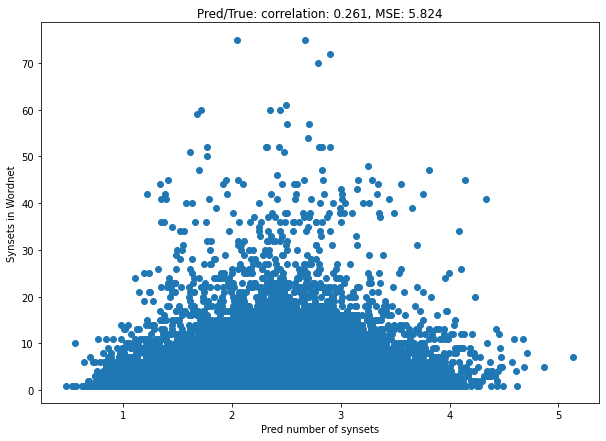

<IPython.core.display.Javascript object>

In [14]:
plot_pred_vs_true_labels(
    y_pred, y_train, xlabel="Pred number of synsets", ylabel="Synsets in Wordnet"
)

In [15]:
y_pred_test = lasso_cv.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred_test)
print(f"MSE on test: {test_mse}")

MSE on test: 14.23958833485504


<IPython.core.display.Javascript object>

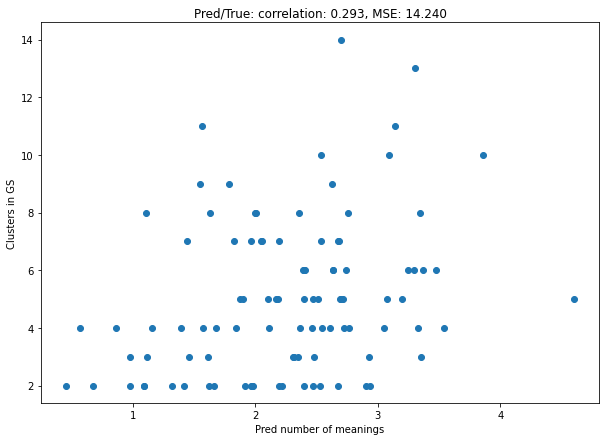

<IPython.core.display.Javascript object>

In [16]:
plot_pred_vs_true_labels(
    y_pred_test, y_test, xlabel="Pred number of meanings", ylabel="Clusters in GS"
)